In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

%matplotlib inline

$\newcommand{\d}[2]{\frac{\mathrm{d}{#1}}{\mathrm{d}{#2}}}$We begin by addressing coordinate transformations in the vertical. First, we look at conversions between optical depth and pressure. To capture band-broadening effects, we will write $\kappa = 2Cp$ for some yet-to-be-determined constant of proportionality $C$. Then
$$\d{\tau}{p} = -\frac{2Cp}{g}$$
which can be integrated to yield
$$-g\tau = Cp^2 + D$$
for a constant of integration $D$. We have two boundary conditions: $\tau(p = 0) = \tau_\infty$ and $\tau(p = p_\textrm{s}) = 0$, where $p_\textrm{s}$ is some reasonable surface pressure. These conditions ultimately amount to
$$p = p_\textrm{s}\left(1 - \frac{\tau}{\tau_\infty}\right)^{1/2}$$
Then hydrostatic balance gives
$$\d{p}{z} = -\frac{gp}{RT}$$
If we replace $T$ by a constant $T_0$, the above can be solved as
$$z = -\frac{RT_0}{g}\ln \frac{p}{p_\textrm{s}}$$
What we will actually need is expressions relating $\tau$ and $z$. Eliminating pressure, these are
$$\boxed{z = -\frac{RT_0}{2g}\ln\left(1 - \frac{\tau}{\tau_\infty}\right) \textrm{ or } \tau = \tau_\infty\left(1 - e^{-(2gz)/(RT_0)}\right)}$$
For now, we just take $T_0 = 260 \textrm{ K}$, and define it along with the other necessary constants below. For Earth-like results, we should take $2 \leq \tau_\infty \leq 5$.

In [2]:
tau_inf = 3
R = 287.1
g = 9.8
T_0 = 260

With this in hand, we provide functions for coordinate transformations in both directions.

In [3]:
def z_from_tau(tau):
    return -((R * T_0) / (2 * g)) * np.log(1 - (tau / tau_inf))

def tau_from_z(z):
    return tau_inf * (1 - np.exp(-(2 * g * z) / (R * T_0)))

Next, we treat the radiation problem. Let us state the gray gas radiative transfer problem. The upward and downward fluxes, expressed as function of the optical thickness $\tau$, are denoted $I_+$ and $I_-$, respectively. The system of equations to be solved is then
$$
\begin{align*}
\d{}{\tau}I_+ &= -I_+ + \sigma T^4 \\
\d{}{\tau}I_- &= I_- - \sigma T^4
\end{align*}
$$
where in the above $T$ is also a function of $\tau$. For convenience, we define the solar flux received by the planet
$$F \equiv \frac{S_0}{4}(1 - \alpha)$$
Then the boundary condition at the bottom of the atmosphere is
$$I_+(0) = I_-(0) + F$$
which indicates that the surface is in equilibrium, with the downwelling longwave and solar fluxes balanced by upwelling radiation solely in the infrared. Meanwhile, the boundary conditions at the top of the atmosphere are
$$
\begin{align*}
I_+(\tau_\infty) &= F \\
I_-(\tau_\infty) &= 0
\end{align*}
$$
which ensures that the planet is in equilibrium with space.

Now, given any profile $T(\tau)$, it is fairly straightforward to calculate the resulting radiation profiles, if not analytically then numerically. However, we wish to choose the particular temperature profile that removes residual heating. That is, we would like the solutions to satisfy
$$\d{}{\tau}\left[I_+ - I_-\right] = 0 \textrm{ for all } \tau \in [0, \tau_\infty]$$
for all $\tau$. Employing either boundary condition, this is equivalent to
$$I_+ - I_- = F \textrm{ for all } \tau \in [0, \tau_\infty]$$

The divergence-free condition can be written as
$$\d{}{\tau}I_+ = \d{}{\tau}I_-$$
Then, using the expressions from the original gray gas system and rearranging, we get
$$\zeta \equiv 2\sigma T^4 = I_+ + I_-$$
Purely as a notational convenience, we will solve for $\zeta$ and then trivially recover $T$. Differentiating the above gives a differential equation for $\zeta$:
$$
\begin{align*}
\d{\zeta}{\tau} &= \d{}{\tau}I_+ + \d{}{\tau}I_- \\
 &= -(I_+ - I_-) \\
 &= -F
\end{align*}
$$
Moreover, we can use the boundary conditions on radiation at the top of the atmosphere to write
$$
\begin{align*}
\zeta(\tau_\infty) &= I_+(\tau_\infty) + I_-(\tau_\infty) \\
 &= F
\end{align*}
$$
Thus we have an easily solvable differential equation for $\zeta$. The solution is
$$\zeta(\tau) = F(1 + \tau_\infty - \tau)$$
Finally, using the original definition of $\zeta$, we can compute the temperature profile in terms of $\tau$
$$\boxed{T(\tau) = \left(\frac{F\left(1 + \tau_\infty - \tau\right)}{2\sigma}\right)^{1 / 4}}$$
Let us declare the necessary constants.

In [4]:
sigma = 5.67e-8
S_0 = 1362
alpha = 0.3

We calculate $F$ as defined above.

In [5]:
F = S_0 * (1 - alpha) / 4

At last, we implement the temperature profile calculated above.

In [6]:
def T_rad(tau):
    return ((F / (2 * sigma)) * (1 + tau_inf - tau)) ** (1 / 4)

Let us declare some coordinate arrays and calculate the temperature profile in radiative equilibrium. The `RuntimeWarning` is just indicating that the point at $\tau_\infty$ is being mapped to $z = \infty$, which is the expected behavior.

In [7]:
tau = np.linspace(0, tau_inf, 5000)
z = z_from_tau(tau)
T_rad_prof = T_rad(tau)

<ipython-input-3-7c8878c6c747>:2: RuntimeWarning: divide by zero encountered in log
  return -((R * T_0) / (2 * g)) * np.log(1 - (tau / tau_inf))


We plot the profile in $z$ coordinates.

Text(0, 0.5, '$z$ (m)')

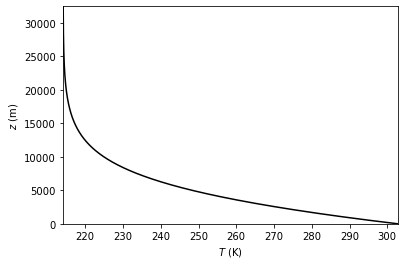

In [8]:
_, ax = plt.subplots()
ax.plot(T_rad_prof, z, color='k')

ax.set_xlim(T_rad_prof.min(), T_rad_prof.max())
ax.set_ylim(0, z[-2])

ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$z$ (m)')

In addition, we might also be interested in the temperature of the atmosphere right above the surface.

In [9]:
print('bottom of atmosphere temperature:', round(T_rad_prof[0], 2), 'K')

bottom of atmosphere temperature: 302.81 K


Next, we want to be able to calculate the actual radiative fluxes - that is, $I_+$ and $I_-$ as defined above. We use the `scipy.integrate.odeint` solver.

In [10]:
def radiative_fluxes(T_func):
    def odefunc(I, tau):
        diss = sigma * (T_func(tau) ** 4)
    
        out = np.zeros(2)
        out[0] = -I[0] + diss
        out[1] = I[1] - diss
    
        return out
    
    I = odeint(odefunc, y0=np.array([F, 0]), t=tau[::-1])
    return I.T[:, ::-1]

We can use the above function to calculate the radiative flux profiles for radiative equilibrium. In particular, we can compute the ground temperature.

In [11]:
I_plus, I_minus = radiative_fluxes(T_rad)
T_g = (I_plus[0] / sigma) ** (1 / 4)
print('ground temperature:', round(T_g, 2), 'K')

ground temperature: 320.18 K


Finally, for radiative-convective equilibrium, we wish to choose a tropopause height so that the troposphere heating works out to zero. That is, we want
$$
\begin{align*}
0 &= \int_0^{\tau_\textrm{tp}} \d{}{\tau}\left[I_+ - I_-\right] \mathrm{d} \tau \\
 &= \left(I_+ - I_-\right)\bigg|_0^{\tau_\textrm{tp}} \\
\end{align*}
$$
where $\tau_\textrm{tp}$ is the optical depth at the top of the troposphere. For lack of a better method, we simply iterate over a wide range of plausible heights, and choose the one for which the troposphere heating comes closest to zero. First, though, we need to declare the lapse rate - we use the moist average, so that $\Gamma = -7.5 \textrm{ K km}^{-1}$.

In [12]:
Gamma = -7.5e-3

Now, we implement the loop.

In [13]:
best_score, best_i = np.inf, None
for i in range(3000, 4900):
    def T_func(tau):
        lev = z_from_tau(tau)
        
        if lev >= z[i]:
            return T_rad(tau)
        else:
            return T_rad_prof[i] - Gamma * (z[i] - lev)
        
    I_plus, I_minus = radiative_fluxes(T_func)
    score = abs(I_plus[i] - I_minus[i] - I_plus[0] + I_minus[0])
    if score < best_score:
        best_score = score
        best_i = i
        
print('tropopause height:', round(z[best_i], 2), 'm')
print('troposphere heating:', round(best_score, 2), 'W m^-2')

<ipython-input-3-7c8878c6c747>:2: RuntimeWarning: divide by zero encountered in log
  return -((R * T_0) / (2 * g)) * np.log(1 - (tau / tau_inf))


tropopause height: 7591.92 m
troposphere heating: 0.42 W m^-2


We implement a function to calculate the temperature profile in radiative-convective equilibrium.

In [14]:
def T_rce(tau):
    lev = z_from_tau(tau)

    if lev >= z[best_i]:
        return T_rad(tau)
    else:
        return T_rad_prof[best_i] - Gamma * (z[best_i] - lev)

Now, we can plot the temperature profiles of radiative and radiative-convective equilibria side-by-side.

<ipython-input-3-7c8878c6c747>:2: RuntimeWarning: divide by zero encountered in log
  return -((R * T_0) / (2 * g)) * np.log(1 - (tau / tau_inf))


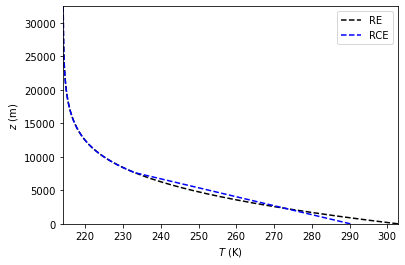

In [15]:
T_rce_prof = np.array([T_rce(t) for t in tau])

_, ax = plt.subplots()
ax.plot(T_rad_prof, z, color='k', ls='dashed', label='RE')
ax.plot(T_rce_prof, z, color='b', ls='dashed', label='RCE')

ax.set_xlim(T_rad_prof.min(), T_rad_prof.max())
ax.set_ylim(0, z[-2])

ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$z$ (m)')

ax.legend()

Finally, we can look at the temperatures of the bottom of the atmosphere and the ground under RCE.

In [16]:
I_plus, I_minus = radiative_fluxes(T_rce)
T_g = (I_plus[0] / sigma) ** (1 / 4)

print('bottom of atmosphere temperature:', round(T_rce_prof[0], 2), 'K')
print('ground temperature:', round(T_g, 2), 'K')

bottom of atmosphere temperature: 290.21 K
ground temperature: 316.05 K


<ipython-input-3-7c8878c6c747>:2: RuntimeWarning: divide by zero encountered in log
  return -((R * T_0) / (2 * g)) * np.log(1 - (tau / tau_inf))
